In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsparse import SparseTensor
import torchsparse.nn as spnn
import scipy


ImportError: /home/nguyen.trungh/.local/lib/python3.10/site-packages/torchsparse/backend.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN2at4_ops5zeros4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEE

In [ ]:
def scatter_nd(indices, updates, shape):
    """pytorch edition of tensorflow scatter_nd.
    this function don't contain except handle code. so use this carefully
    when indice repeats, don't support repeat add which is supported
    in tensorflow.
    """
    ret = torch.zeros(*shape, dtype=updates.dtype, device=updates.device)
    ndim = indices.shape[-1]
    output_shape = list(indices.shape[:-1]) + shape[indices.shape[-1]:]
    flatted_indices = indices.view(-1, ndim)
    slices = [flatted_indices[:, i] for i in range(ndim)]
    slices += [Ellipsis]
    ret[slices] = updates.view(*output_shape)
    return ret

def to_dense(sp, bs, shape):
    ndim = len(shape)
    trans_params = list(range(ndim))
    trans_params.insert(0, ndim)
    C = sp.feats.size(1)
    indices = sp.coords[:,trans_params]
    
    output_shape = [bs, *shape, C]
    res = scatter_nd(
        indices.to(sp.feats.device).long(), sp.feats,
        output_shape)

    trans_params = list(range(0, ndim + 1))
    trans_params.insert(1, ndim + 1)
    return res.permute(*trans_params).contiguous()

In [ ]:
input_size=[32,32,32]
num_samples=1
sparsity=0.01
seed=2
r = np.random.default_rng(seed=seed)
size = tuple([num_samples] + input_size)
_mask = r.random(size=size) < sparsity
_mask = scipy.ndimage.binary_dilation(_mask[0], iterations=1, structure=np.ones([3]*len(input_size)))[np.newaxis,...]

mask = torch.tensor(_mask).to_sparse().coalesce()
indices = mask.indices().permute(1,0)[:, [1, 2, 3, 0]].type(torch.int32)
features = r.random(size=(len(indices),1))
features = np.ones_like(features)
features = torch.tensor(features).float()

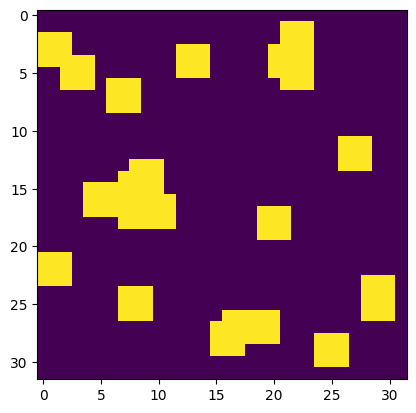

In [ ]:
plt.imshow(_mask[0][0])
plt.show()

In [ ]:
x = SparseTensor(coords=indices.cuda(), feats=features.cuda())

In [3]:
# plt.imshow(to_dense(x, 1, input_size)[0,0].detach().cpu().numpy())
# plt.show()

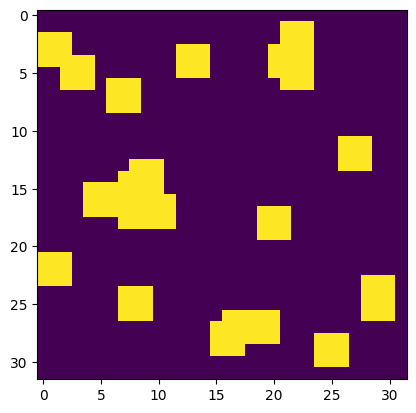

In [ ]:
for i in range(1):
    plt.imshow(to_dense(x, 1, input_size)[0,0,i].detach().cpu().numpy())
    plt.show()

In [2]:
conv = spnn.Conv3d(
            in_channels=1,
            out_channels=2,
            kernel_size=3,
            stride=2,
            bias=False,
        )
nn.init.constant_(conv.kernel, 1.)
conv = conv.cuda()
z = conv(x)
len(z.coords), len(x.coords)

NameError: name 'spnn' is not defined

In [8]:
z.coords[:,:3] //=2


/tmp/ipykernel_48230/3390892832.py:1: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/BinaryOps.cpp:577.)
  z.coords[:,:3] //=2


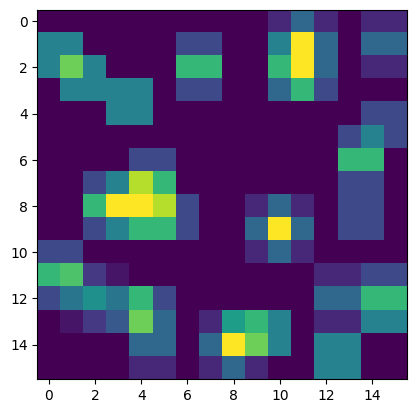

In [9]:
for i in range(1):
    plt.imshow(to_dense(z, 1, [16,16,16])[0,0,i].detach().cpu().numpy())
    plt.show()